# Evolution of Proteins tutorial

## Loading the data

First lets load the data. For the purposes of this tutorial a small sample dataset of 1000 proteins has been created. If we run the pipeline of the data-loader it will load the data, sort the proteins from longest to shortest and finally create a train/test split. We can then pass the data to the data-iterator, so that we can easily iterate over the data when training. 

If the tqdm package is not installed, then uncomment the line so it will be installed. 

In [44]:
# !pip install tqdm

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model import BiRNN_CRF
from data import DataLoader, DataIterator
from utils import custom_cross_entropy, build_mask, cosine_similarity

In [19]:

batch_size = 16

data_path = "data/testset.txt"
data_loader = DataLoader(data_path, verbose=True)

X, y, seq = data_loader.run_pipeline(0.2) # splits data into train/test with ratio 1:4

train_iter = DataIterator(X[0], y[0], seq[0], batch_size=batch_size)
test_iter = DataIterator(X[1], y[1], seq[1], batch_size=batch_size)


Loading Data: 100%|##########| 1001/1001 [00:00<00:00, 1123.96lines/s]



## Creating model and optimizer

Creating the model is done in the following way. We can choose to either use softmax outputs or crf outputs by setting the crf_on flag. The hyperparameters such as embedding dimension and RNN size are passed as arguments. We use Adam optimizer and a custom cross-entropy error function.

To see the full implementation of the model see the **model.py** file.

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

crf_on = False

model = BiRNN_CRF(device, embedding_dim=64,
         rnn_hidden_size=256, rnn_layers=2,
         rnn_dropout=0.5, hidden_linear_units=100,
         classes=20, linear_dropout=0.5, crf_on=crf_on)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
criterion = custom_cross_entropy

print("Using device: {}".format(device))
print(model)

Using device: cpu
BiRNN_CRF(
  (embedding): Embedding(21, 64)
  (LSTM): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5)
  (linear_hidden): Linear(in_features=512, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=20, bias=True)
)


## Training Loop

We can now create a training loop as the following.
Whilst training we record errors and accuracy of the models. The accuracy is measured as the cosine similarity of the predicted profile to the target profile.


In [25]:
train_err, test_err = [], []
train_acc, test_acc = [], []
nr_epochs = 5

for epoch in range(nr_epochs):

    print("Epoch: {} / {}".format(epoch+1, nr_epochs))

    ### TRAIN LOOP ###
    err = []
    acc = []
    model.train()
    for proteins, sequence_lengths, targets in tqdm(train_iter, ascii=False, desc="Training", total=int(len(X[0]) / batch_size), unit="batch"):

        inputs = proteins.to(device)
        seq_lens = sequence_lengths.to(device)
        targets = targets.to(device)

        predictions = model(inputs, seq_lens)

        mask = build_mask(sequence_lengths).to(device)

        optimizer.zero_grad()
        batch_loss = criterion(predictions, targets, mask)
        batch_loss.backward()
        optimizer.step()

        cos_sim = cosine_similarity(predictions, targets, mask)

        err.append(batch_loss.cpu().item())
        acc.append(cos_sim.cpu().item())

    epoch_trainig_error = sum(err) / len(err)
    epoch_training_accuracy = sum(acc) / len(acc)
    train_err.append(epoch_trainig_error)
    train_acc.append(epoch_training_accuracy)


    ### TEST LOOP ###
    err = []
    acc = []
    model.eval()
    for proteins, sequence_lengths, targets in tqdm(test_iter, ascii=False, desc="Testing", total=int(len(X[1]) / batch_size), unit="batch"):

        inputs = proteins.to(device)
        seq_lens = sequence_lengths.to(device)
        targets = targets.to(device)

        predictions = model(inputs, seq_lens)      

        mask = build_mask(sequence_lengths).to(device)

        batch_loss = criterion(predictions, targets, mask)

        cos_sim = cosine_similarity(predictions, targets, mask)

        err.append(batch_loss.cpu().item())
        acc.append(cos_sim.cpu().item())

    epoch_test_error = sum(err) / len(err)
    epoch_test_accuracy = sum(acc) / len(acc)
    test_err.append(epoch_test_error)
    test_acc.append(epoch_test_accuracy)

    print("Training error: {0:.4f},\tTest error: {1:.4f}\t\tTraining accuracy: {2:.4f}\tTest accuracy: {3:.4f}"
          .format(epoch_trainig_error, epoch_test_error, epoch_training_accuracy, epoch_test_accuracy))

Epoch: 1 / 1


HBox(children=(IntProgress(value=0, description='Training', max=50, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Testing', max=12, style=ProgressStyle(description_width='initial')), HTML(value='')))


Training error: 2.8930,	Test error: 2.8435		Training accuracy: 0.6905	Test accuracy: 0.7216


## Results

We can now print the results of the model.


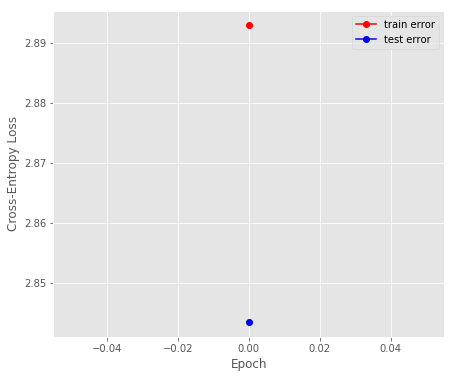

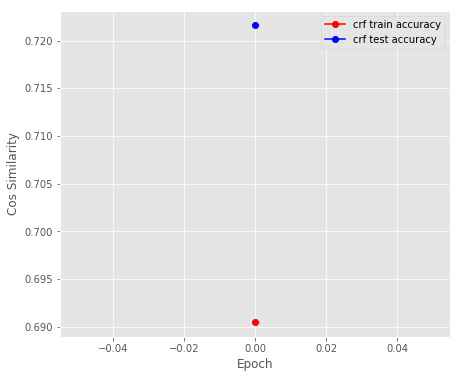

In [30]:
plt.style.use('ggplot')
plt.figure(0, figsize=(7,6))
plt.plot(train_err, "o-", c="r", label="train error")
plt.plot(test_err, "o-", c="b", label="test error")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

plt.figure(1, figsize=(7,6))
plt.plot(train_acc, "o-", c="r", label="crf train accuracy")
plt.plot(test_acc, "o-", c="b", label="crf test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Cos Similarity")
plt.legend()
plt.show()

## Predictions

The following shows the output of the model given a batch of protein sequences.

In [43]:
proteins, seq_lens, profiles = next(train_iter)

predictions = model(proteins, seq_lens)

print("Protein sequence:\n")
print(proteins[0])
print(proteins.shape)
print("\n")

print("Profile of protein:\n")
print(profiles[0])
print(profiles.shape)
print("\n")

print("Model prediction:\n")
print(predictions[0])
print(predictions.shape)


Protein sequence:

tensor([ 3,  8,  7, 16, 10,  8, 16, 13, 19, 14,  0, 16,  7, 11, 14, 11, 17, 16,
         0,  5,  0,  3,  0,  6, 16, 10, 10, 16,  0,  3,  0,  6,  0,  9, 18, 10,
        10, 16, 11,  3,  1,  1, 10,  1,  0, 19,  7,  1, 15,  3,  0,  1, 19,  1,
        17, 16,  0,  1, 10, 14,  6,  3, 13,  7, 11, 16,  9, 10, 14,  1, 14, 19,
         0,  8,  1,  7,  1, 10, 19,  9, 16, 16, 15, 16,  7,  8, 19, 12,  0, 19,
         2, 16,  3, 15,  7,  1, 16,  6, 17, 16,  0,  8,  3, 10,  0, 11,  6,  1,
        15, 10, 13, 14,  0,  0,  1,  2,  7,  9, 19, 19, 10,  2,  7, 11, 16, 10,
         0,  0,  1, 15,  9, 10,  3,  7, 11,  5, 10, 17,  0, 18, 16,  6,  2,  0,
        18, 18,  3,  8, 15,  1, 11,  6, 17,  7,  1, 14, 15,  9, 18,  7,  3, 19,
        19, 18, 16, 10,  7,  4,  3, 16,  5,  7, 18,  7, 13, 14, 12,  0, 13,  3,
        19,  1, 15,  7, 11, 11,  5, 17,  6,  7,  7, 19,  0, 10,  7, 15,  2,  3,
         2, 14,  9, 10,  1,  5,  7,  8,  7, 19, 17, 10, 10,  3,  8,  7, 14, 19,
        14, 16, 19, 1